## Data Visualization Notebook

To minimize notebook runtimes, vizualizations from the Tropical Storm Classification Project are being run separately here. 

### Recreating Dataframes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [3]:
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.tree import DecisionTreeClassifier 

In [4]:
df = pd.read_csv('data/ibtracs.since1980.list.v04r00.csv', dtype='object', parse_dates=True, skiprows=[1], na_values=' ')
df.columns = [x.lower() for x in df.columns]

In [5]:
#removing unclassified rows
df.drop(df.loc[df['nature'] == 'NR'].index, inplace=True)
df.drop(df.loc[df['nature'] == 'MX'].index, inplace=True)

#new column  
df['target'] = 0

# loop through the data and input a 1 where the storm is a Tropical storm
for row in df.index:
    if df['nature'][row] == 'TS':
        df['target'][row] = 1

In [6]:
initial_feats = ['sid', 'season', 'basin', 'subbasin', 'lat', 'lon', 
                 'wmo_wind', 'dist2land', 'storm_speed', 'storm_dir']
xs_df = df[initial_feats]

xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']] = xs_df[['lat', 'lon', 'dist2land', 'season', 'wmo_wind', 'storm_speed', 'storm_dir']].apply(pd.to_numeric)

#taking my datetime object and pulling out the week as a feature
df['iso_time'] = pd.to_datetime(df['iso_time'])
xs_df['week_of_year'] = df['iso_time'].dt.week

In [7]:
y_df = df['target'].to_frame()
clean_df = pd.concat([xs_df, y_df], axis=1)
clean_df.head()

,sid,season,basin,subbasin,lat,lon,wmo_wind,dist2land,storm_speed,storm_dir,week_of_year,target
0,1980001S13173,1980,SP,MM,-12.5000,172.500,NaN,647,6.0,351.0,1,1
1,1980001S13173,1980,SP,MM,-12.1927,172.441,NaN,653,6.0,351.0,1,1
2,1980001S13173,1980,SP,MM,-11.9144,172.412,NaN,670,5.0,358.0,1,1
3,1980001S13173,1980,SP,MM,-11.6863,172.435,NaN,682,4.0,12.0,1,1
4,1980001S13173,1980,SP,MM,-11.5000,172.500,NaN,703,4.0,22.0,1,1


In [8]:
grouped_df = clean_df.groupby(['sid']).max()
grouped_df.head()

,season,lat,lon,wmo_wind,dist2land,storm_speed,storm_dir,week_of_year,target
sid,,,,,,,,,
1980001S13173,1980,-11.1525,189.5,65.0,934,22.0,358.0,1,1
1980002S15081,1980,-13.8825,80.0,29.0,2230,7.0,320.0,1,1
1980003S15137,1980,-14.6600,161.0,50.0,818,26.0,237.0,2,1
1980005S11059,1980,-11.0000,59.0,25.0,1014,35.0,308.0,1,1
1980005S14120,1980,-13.6333,120.7,115.0,490,20.0,339.0,2,1


### Feature Exploration Visualizations

#### Correlation Marix

In [9]:
#removing non-numericals
plot_df = clean_df.drop(['subbasin', 'basin'], axis=1)
plot_df.columns

Index(['sid', 'season', 'lat', 'lon', 'wmo_wind', 'dist2land', 'storm_speed',
       'storm_dir', 'week_of_year', 'target'],
      dtype='object')

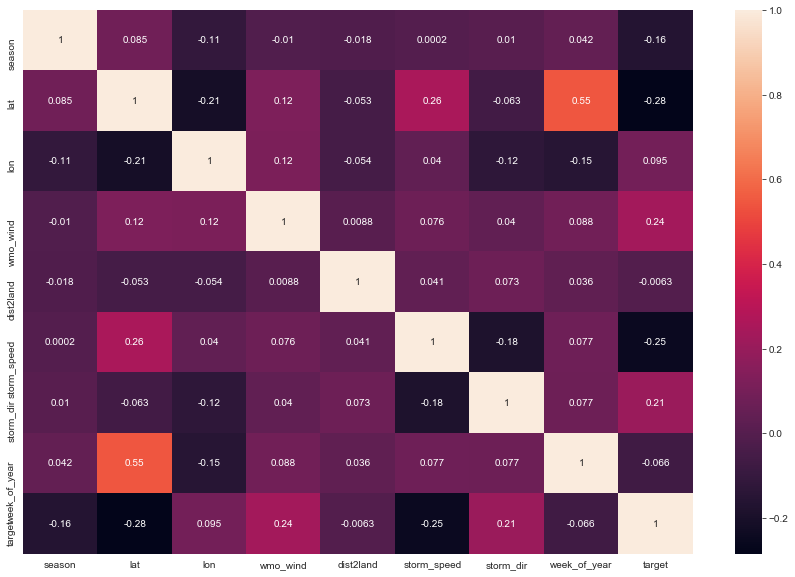

In [17]:
plt.figure(figsize = (15,10))
ax = sns.heatmap(plot_df.corr(), annot=True)
ax.set_ylim(9,0)

plt.savefig('images/correlation_matrix')

#### Pairplot

<Figure size 720x576 with 0 Axes>

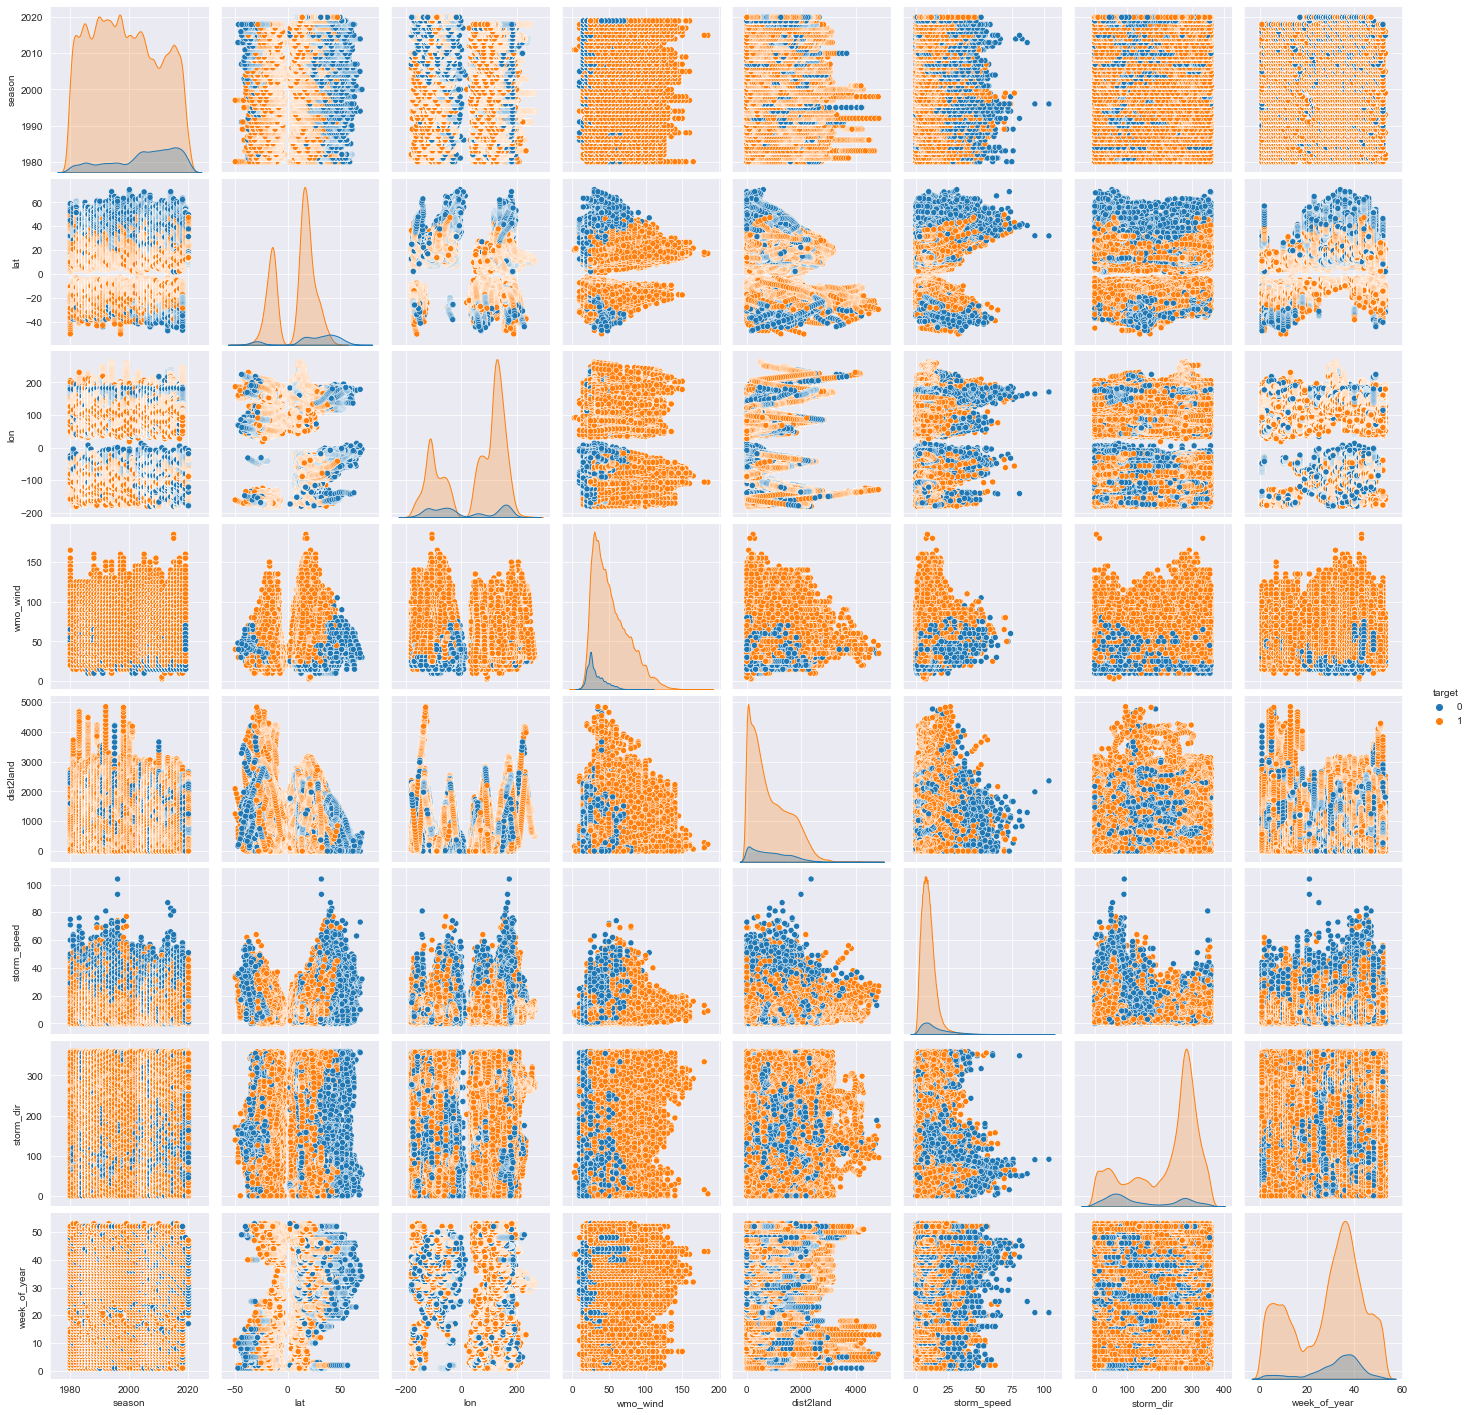

In [11]:
plt.figure(figsize=(10,8))

sns.pairplot(plot_df, hue='target')

plt.savefig('images/pairplot')

In [12]:
# sns.pairplot(new_data,
#     x_vars=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'condition', 'grade', 'yr_built', 'is_renovated', 'zipcode'],
#     y_vars=['price'])

In [13]:
map_df = clean_df[['sid', 'lat', 'lon', 'season', 'week_of_year', 'target']]

In [14]:
map_df['sid'].nunique()

3912

In [15]:
test_table = map_df.loc[map_df['sid'] == map_df['sid'][3]]
test_table.head()

,sid,lat,lon,season,week_of_year,target
0,1980001S13173,-12.5000,172.500,1980,1,1
1,1980001S13173,-12.1927,172.441,1980,1,1
2,1980001S13173,-11.9144,172.412,1980,1,1
3,1980001S13173,-11.6863,172.435,1980,1,1
4,1980001S13173,-11.5000,172.500,1980,1,1


In [16]:
lat_points = []
lon_points = []

for i in range(0, 3912)
    table = map_df.loc[map_df['sid'] == map_df['sid'][i]]
    lat_points.append(list(table['lat']))
    lon_points.append(list(table['lon']))
    
    fig = px.line_mapbox(test_table, lat="lat", lon="lon", color="target", zoom=3, height=300)

    fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0})

    fig.show()
    
    

SyntaxError: invalid syntax (<ipython-input-16-afdc647ebf1b>, line 4)

In [ ]:
#test
fig = px.line_mapbox(test_table, lat="lat", lon="lon", color="target", zoom=3, height=300)

fig.update_layout(mapbox_style="stamen-terrain", mapbox_zoom=4, mapbox_center_lat = 41,
    margin={"r":0,"t":0,"l":0,"b":0})

fig.show()